In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
from scipy import optimize
from datetime import datetime

def sort_dates_chronologically(dates):
    # Convert each date string to a datetime object and keep track of the original indexes
    indexed_dates = [(i, datetime.strptime(date, '%m/%d/%Y %H:%M:%S')) for i, date in enumerate(dates)]
    
    # Sort the list of tuples by the datetime object
    sorted_indexed_dates = sorted(indexed_dates, key=lambda x: x[1])
    
    # Extract and return the list of original indexes
    sorted_indexes = [index for index, date in sorted_indexed_dates]
    return sorted_indexes

def get_time_diff(date_str1,date_str2):
    date1 = datetime.strptime(date_str1, '%m/%d/%Y %H:%M:%S')
    date2 = datetime.strptime(date_str2, '%m/%d/%Y %H:%M:%S')
    t = date2-date1
    return abs(t.total_seconds())/60# units in minutes

def plot_polyfit(x_data,poly_coefficents):
    l = len(x_data)
    output = np.zeros(l)
    for i,a in enumerate(poly_coefficents[::-1]):
        for j in range(l):
            output[j] += a*x_data[j]**i 
    return output

def full_lorenzian_fit_with_skew(fs, f0,Q,Smax,A1,A2,A3):#fs is the data, f0 is the resonance freq
    return A1 + A2*fs + (Smax+A3*fs)/np.sqrt(1+4*(Q*(fs/f0-1))**2)#this is eq 10 from Measurement of resonant frequency and quality factor of microwave resonators: Comparison of methods Paul J. Petersan; Steven M. Anlage

def calc_mu(omega,rho_a,rho_c,length=2e-3,width=1e-3,tolerance = 1e-6):
    mu_0 = 4*np.pi*1e-7
    total_sum = 0
    n = 1
    change = np.inf
    while np.abs(change)>tolerance:
        alpha_n = np.sqrt(-1j*(omega*mu_0*(length/np.pi)**2/rho_c-1j*rho_a/rho_c*(length*n/width)**2))
        gamma_n = np.sqrt(-1j*(omega*mu_0*(width/np.pi)**2/rho_a-1j*rho_c/rho_a*n**2))

        change = (np.tan(np.pi*alpha_n/2)/alpha_n+np.tan(np.pi*gamma_n/2)/gamma_n)/n**2
        total_sum += change
        n += 2
    return total_sum*16/(np.pi)**3

def cosort_lists(list_to_sort,list_to_cosort):
    out1 = np.zeros(l1 := len(list_to_sort))
    out2 = np.zeros(len(list_to_cosort))
    sorted_inds = np.argsort(np.argsort(list_to_sort))
    for i in range(l1):
        for j, ind in enumerate(sorted_inds):
            if i == ind:
                out1[i] = list_to_sort[j]
                out2[i] = list_to_cosort[j]
                break
    return out1, out2

def chi_squared(y_data, y_fitted):
    """
    Calculate the chi-squared value for given observed and fitted data.
    
    Parameters:
    y_data (array-like): Observed data points.
    y_fitted (array-like): Fitted data points from the model.
    
    Returns:
    float: The chi-squared value.
    """
    residuals = y_data - y_fitted
    chi_sq = np.sum((residuals**2) / y_fitted)
    return chi_sq


def find_f(ratio = 1.1):
    try:
        if ratio <1:
            ratio = 1/ratio
        elif ratio == 1:
            return 1
        R1 = 1
        R2 = ratio
        def vanderpauw(f,R1= R1,R2= R2):
            return np.arccosh(np.exp(np.log(2)/f)/2)+np.log(2)*(R1-R2)/(R1+R2)/f
        # print(optimize.root_scalar(vanderpauw, bracket=[1e-9, 1], method='brentq'))
        return optimize.root_scalar(vanderpauw, bracket=[1e-1, 1], method='brentq').root
    except:
        output = np.zeros(len(ratio))
        for i, rat in enumerate(ratio):
            if rat <1:
                rat = 1/rat
            elif rat == 1:
                return 1
            R1 = 1
            R2 = rat
            def vanderpauw(f,R1= R1,R2= R2):
                return np.arccosh(np.exp(np.log(2)/f)/2)+np.log(2)*(R1-R2)/(R1+R2)/f
            output[i] = optimize.root_scalar(vanderpauw, bracket=[1e-1, 1], method='brentq').root
        return output



Get Contacted Data

Ch1STO_D_Ch2STO_E_Ch3TiNiSn.dat

Ch1STO_D_Ch2STO_E_Ch3TiNiSnwarmup.dat

['R1 Ch1STO_D_Ch2STO_E_Ch3TiNiSn.dat', 'R2 Ch1STO_D_Ch2STO_E_Ch3TiNiSn.dat', 'R1 Ch1STO_D_Ch2STO_E_Ch3TiNiSnwarmup.dat', 'R2 Ch1STO_D_Ch2STO_E_Ch3TiNiSnwarmup.dat']
6.224725660449653 0.8318240809620775


<__array_function__ internals>:180: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


2.7453883548183424 0.5676596055956573


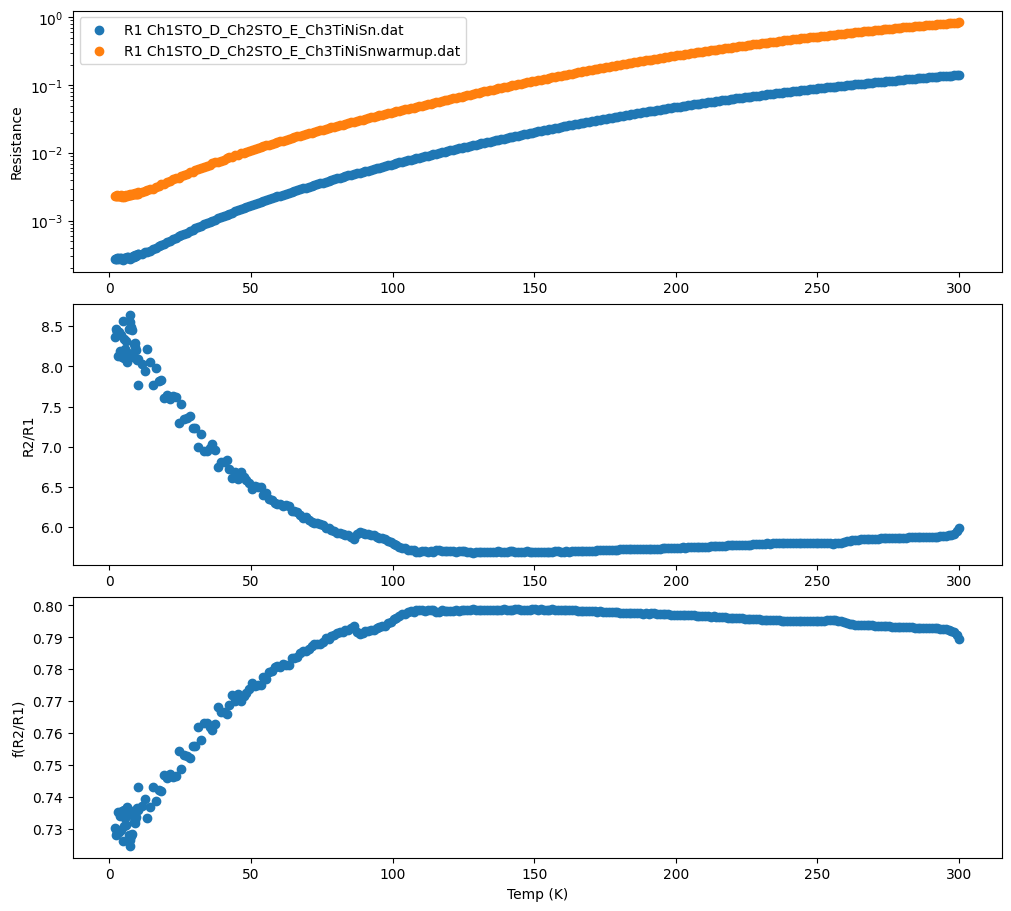

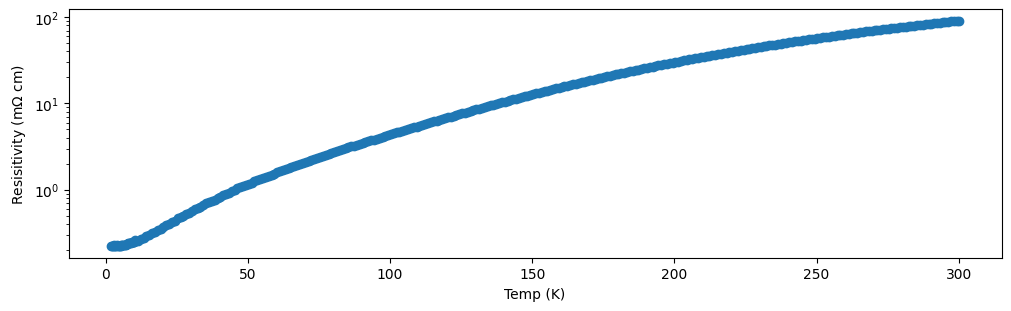

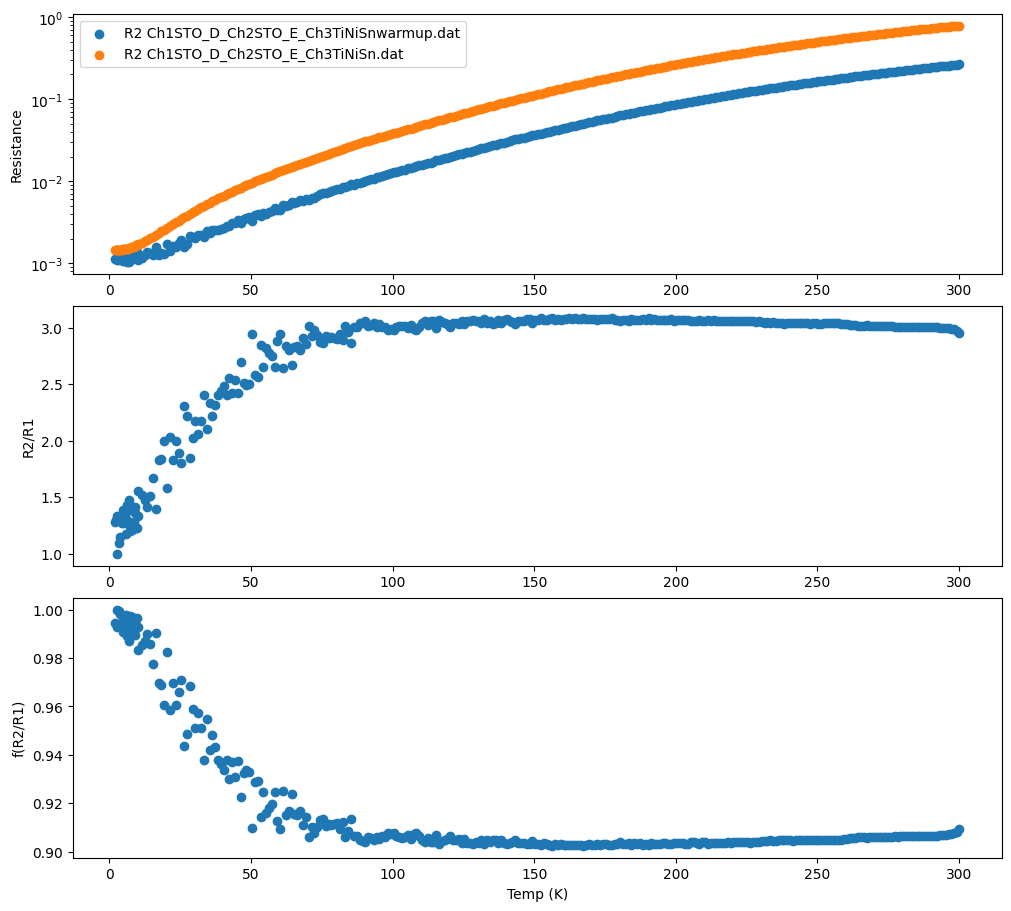

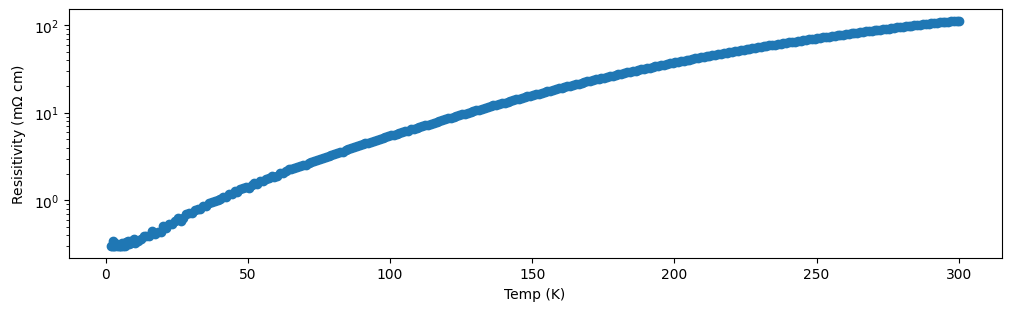

In [2]:
res_temps = []
resistances = []
titles = []

#import files by hand
contacted_files = [
    # 'C:/Users/blake/Documents/VSCode/Python/Greven/RawData/ContactedResistivity/STO/C1_STO_C2GdPtBi_C3_STO_00001.dat',#(Channel 1 is deformed before the anneal and Channel 3 is undeformed)
    
    # 1D resisitivity attempts
    # 'C:/Users/blake/Documents/VSCode/Python/Greven/RawData/ContactedResistivity/STO/STO_D_undef_ch1__shortside_RyyvsT_warming.dat',
    # 'C:/Users/blake/Documents/VSCode/Python/Greven/RawData/ContactedResistivity/STO/STO_D_undef_ch2_RxxvsT_warming.dat',
    # 'C:/Users/blake/Documents/VSCode/Python/Greven/RawData/ContactedResistivity/STO/STO_OVD_1050C_4hr_3p0def_ch1_RyyvsT_warming.dat',
    # 'C:/Users/blake/Documents/VSCode/Python/Greven/RawData/ContactedResistivity/STO/STO_OVD_1050C_4hr_3p0def_ch2_RxxvsT_warming.dat',

    #proper vanderpauw
    'C:/Users/blake/Documents/VSCode/Python/Greven/RawData/ContactedResistivity/STO/Ch1STO_D_Ch2STO_E_Ch3TiNiSn.dat',
    'C:/Users/blake/Documents/VSCode/Python/Greven/RawData/ContactedResistivity/STO/Ch1STO_D_Ch2STO_E_Ch3TiNiSnwarmup.dat'
    ] 


#import files in a folder
# contacted_files = []
# read_path = 'C:/Users/blake/Documents/VSCode/Python/Greven/RawData/ContactedResistivity/STO/'
# data_paths =  os.listdir(read_path)
# for data_path in data_paths:
#     contacted_files.append(read_path+data_path)


for filename in contacted_files:
    if filename[-3:] == 'dat':
        f = open(filename,'r')
        # Parse Header
        # Skip 1 more row that what is picked out by the loop below. (In order to skip the column headings)
        skip = 1

        # Loop over lines to find the beginning of the data section
        break_next = False
        for line in f:
            if break_next:
                # print(line)
                headers = line.split(',')
                break
            skip += 1
            # Stop at the beginning of the Data section
            if line == "[Data]\n":
                break_next = True
            # Extract the measurement date and time
            else:
                if line[:12] == "FILEOPENTIME":
                    splitLine = line.split(" ")
                    timestamp = splitLine[1]
        print(filename.split('/')[-1])
        time,temp,magfield = np.loadtxt(filename, delimiter=',', skiprows=skip, usecols=(1,3,4), unpack=True)
        
        try:
            R1 = np.loadtxt(filename, delimiter=',', skiprows=skip, usecols=(19))
            res_temps.append(temp)
            resistances.append(R1)
            titles.append('R1 '+filename.split('/')[-1])
        except:
            print('No R1')
        try:
            R2 = np.loadtxt(filename, delimiter=',', skiprows=skip, usecols=(20))
            res_temps.append(temp)
            resistances.append(R2)
            titles.append('R2 '+filename.split('/')[-1])
        except:
            print('No R2')
        # try:
        #     R3 = np.loadtxt(filename, delimiter=',', skiprows=skip, usecols=(21))
        #     res_temps.append(temp)
        #     resistances.append(R3)
        #     titles.append('R3 '+filename.split('/')[-1])
        # except:
        #     print('No R3')
        print()


lengths = np.array([1.348e-3,1.649e-3,1.649e-3]) #in meters along the direction of the current [Deformed A,undeformed D, undeformed D]
widths = np.array([1.135e-3,1.593e-3,1.593e-3])#in meters perpendicular to the direction of the current
heights = np.array([0.521e-3,0.52e-3,0.52e-3])#in meters perpendicular to the direction of the current

#new polished D [1.399e-3, 1.056e-3, 0.521e-3]
# polished STO_E [1.260e-3, 1.080e-3, 0.523e-3]
lengths = np.array([1.399e-3, 1.260e-3])
widths = np.array([1.056e-3, 1.080e-3])
heights = np.array([0.521e-3, 0.523e-3])

# titles = ['6% Deformed STO (anneal after deformation)','','Undeformed STO']

# STO_D_long = .495e-3 #m
# STO_D_short = .271e-3 #m
# STO_D_thickness = 0.52e-3 #m

# lengths = np.array([.495e-3,.271e-3,.495e-3,.271e-3])
# widths = np.array([.271e-3,.495e-3,.271e-3,.495e-3])
# heights = np.ones(len(res_temps))*STO_D_thickness

areas = widths*heights#in meters squared

resistivities = np.zeros_like(resistances)# 1D like sample (rho = R*A/L)
resistivities2 = np.zeros_like(resistances)# naive vanderPauw (R2/R1 = length/width)
resistivities3 = [] # actual vanderpauw


timebounds = []
for temp in res_temps:
    timebounds.append(np.logical_and(temp>0, temp<150))

print(titles)
if len(res_temps) == len(lengths): #this is for simpler resistivitiy approaches
    for i in range(len(res_temps)):
        #plot resistances
        fig1 = plt.figure(constrained_layout = True,figsize=(10,3))
        ax = fig1.add_subplot(1, 1, 1)
        res_temps[i] = np.array(res_temps[i])
        resistances[i] = np.array(resistances[i])
        ax.scatter(res_temps[i][timebounds[i]],resistances[i][timebounds[i]])
        ax.set_xlabel('Temperature (K)')
        ax.set_ylabel(r'Resistance ($\Omega$)')
        ax.set_title(titles[i])
        bx = ax.twinx()



        #convert resistnace to resisitivity
        resistivities[i] = resistances[i]*areas[i]/lengths[i]
        #naive vanderpauw
        f = find_f(lengths[i]/widths[i])
        resistivities2[i] = np.pi*heights[i] * resistances[i]*(1+widths[i]/lengths[i])/2*f/np.log(2) #this assummes isotropic and the current is parallel to the longest side
        



        # fig2 = plt.figure(constrained_layout = True,figsize=(10,3))
        # bx = fig1.add_subplot(1, 2, 2)
        bx.scatter(res_temps[i][timebounds[i]],resistivities[i][timebounds[i]]*1e5,label = 'Rod Like')
        if False:
            bx.scatter(res_temps[i][timebounds[i]],resistivities2[i][timebounds[i]]*1e5,label = 'vanderPauw')
        bx.set_xlabel('Temperature (K)')
        bx.set_ylabel(r'Resistivity (m$\Omega$ cm)')
        bx.set_title(titles[i])
        bx.legend()
        # print(resistivities2[i][j]/resistivities[i][j])

        # #plot 1st and 3 channels together
        # fig, axes = plt.subplots(1, 1,constrained_layout = True)
        # axes.scatter(res_temps[0][timebounds[0]]**1,resistivities[0][0][timebounds[0]]*1e5,label='Channel 1 - Deformed')
        # # axes.scatter(res_temps[0][timebounds[0]],resistivities[0][1][timebounds[0]]*1e5,label='Channel 2 - ')
        # axes.scatter(res_temps[0][timebounds[0]]**1,resistivities[0][2][timebounds[0]]*1e5,label='Channel 3 - Undeformed')
        # axes.set_xlabel('Temperature (K)')
        # axes.set_ylabel(r'Resistivity (m$\Omega$ cm)')
        # axes.legend()
        # axes.set_yscale('log')

        # #sort in order of increasing temperature (for interpolation later)
        _, resistances[i] = cosort_lists(res_temps[i],resistances[i])
        res_temps[i], resistivities[i] = cosort_lists(res_temps[i],resistivities[i])
    # fig1 = plt.figure(constrained_layout = True,figsize=(10,3))
    # ax = fig1.add_subplot(1, 1, 1)
    # ax.scatter(res_temps[0][timebounds[0]],resistances[0][timebounds[0]]/resistances[0][timebounds[0]][-1],label=titles[0])
    # ax.scatter(res_temps[1][timebounds[1]],resistances[1][timebounds[1]]/resistances[1][timebounds[1]][-1],label=titles[1])
    # ax.set_xlabel('Temperature (K)')
    # ax.set_ylabel(r'Resistance ($\Omega$)')
    # ax.legend()

elif len(res_temps) == 2*len(lengths): #designed to handle vanderpauw
    l = len(lengths)
    split_temps = []
    labs_idx = []
    for i in range(l):
        #put them both in order with increasing temp
        res_temps[i], resistances[i] = cosort_lists(res_temps[i],resistances[i])
        res_temps[l+i], resistances[l+i] = cosort_lists(res_temps[l+i],resistances[l+i])

        # decide which resistance measurement has the better temp range
        # if len(res_temps[i])>=len(res_temps[l+i]):
        
        if res_temps[i][0] >= res_temps[l+i][0]:
            RA = resistances[i]
            RB = np.interp(res_temps[i],res_temps[l+i],resistances[l+i])
            split_temps.append(res_temps[i])
            labs_idx += [i,i+l]
        else:
            RA = resistances[l+i]
            RB = np.interp(res_temps[l+i],res_temps[i],resistances[i])
            split_temps.append(res_temps[l+i])
            labs_idx += [i+l,i]

        #pick which one is bigger (usually)
        if np.average(RA/RB) >= np.average(RB/RA):
            R2 = RA
            R1 = RB
            #switch the label indexes
            buffer = labs_idx[l*i]
            labs_idx[l*i] = labs_idx[l*i+1]
            labs_idx[l*i+1] = buffer
        else:
            R1 = RA
            R2 = RB
        print(np.average(R2/R1),np.std(R2/R1))

        #check how consistant R1, R2, R2/R1 and f are
        check = True
        if check:
            fig1 = plt.figure(constrained_layout = True,figsize=(10,9))
            ax = fig1.add_subplot(3, 1, 1)
            bx = fig1.add_subplot(3, 1, 2)
            cx = fig1.add_subplot(3, 1, 3)
            ax.scatter(split_temps[i],R1,label=titles[labs_idx[l*i]])
            ax.scatter(split_temps[i],R2,label=titles[labs_idx[l*i+1]])
            ax.legend()
            ax.set_yscale('log')
            ax.set_ylabel('Resistance')
            bx.scatter(split_temps[i],R2/R1)
            bx.set_ylabel('R2/R1')
            cx.scatter(split_temps[i],find_f(R2/R1))
            cx.set_xlabel('Temp (K)')
            cx.set_ylabel('f(R2/R1)')
            
        f = find_f(R2/R1)
        resistivities3.append(np.pi*heights[i] * (R1+R2)/2*f/np.log(2))

        
        fig2 = plt.figure(constrained_layout = True,figsize=(10,3))
        ax2 = fig2.add_subplot(1, 1, 1)
        ax2.scatter(split_temps[i],1e5*resistivities3[i])
        ax2.set_xlabel('Temp (K)')
        ax2.set_ylabel(r'Resisitivity (m$\Omega$ cm)')
        ax2.set_yscale('log')
        
            


else:
    print('Error: Check the resistance file paths and the inputted dimension info')

    

Open & Read Contactless Data

In [3]:
# files = ['C:/Users/blake/Documents/VSCode/Python/Greven/RawData/HeProbe/UnmeasuredOPEmpty.dat',
#                'C:/Users/blake/Documents/VSCode/Python/Greven/RawData/HeProbe/empty2_21overnight.dat',
#                'C:/Users/blake/Documents/VSCode/Python/Greven/RawData/HeProbe/2023_7_1bBefore.dat',
#                'C:/Users/blake/Documents/VSCode/Python/Greven/RawData/HeProbe/STOempty.dat'
# ]
read_path = 'C:/Users/blake/Documents/VSCode/Python/Greven/RawData/HeProbe/OVDSTO/NewerSTO'

data_paths =  os.listdir(read_path)
files = []
for data_path in data_paths:
    files.append(read_path + '/' +data_path)


all_data = []
headings = []
times = []
temps = []
vxs = []
vys = []
vmags = []
freqs = []
sweep_nums = []
all_Qs = []
all_fs = []
all_times = []
all_temps = []
all_chis = []
guesses1 = [2e3,186,-2.35e3,5e2,-3.3e-2,1.2]
pbounds1 = np.array([[500,1,-1e4,0,-1,-10],[4000,1e3,1e4,2e3,1,10]]) 
for i, filename in enumerate(files):
    all_data.append(np.genfromtxt(filename, delimiter='\t'))
    times.append(np.array(all_data[i][1:,0]))
    temps.append(np.array(all_data[i][1:,1]))
    vxs.append(np.array(all_data[i][1:,2])*1000) #mV
    vys.append(np.array(all_data[i][1:,3])*1000) #mV
    vmags.append(np.array(all_data[i][1:,4])*1000) #mV
    freqs.append(np.array(all_data[i][1:,5])/1000) #kHz
    sweep_nums.append(np.array(all_data[i][1:,6]))
    headings.append(np.genfromtxt(filename, delimiter='\t',dtype=str)[0])


for j in range(len(all_data)):
    max_sweep = int(np.max(sweep_nums[j]))
    if max_sweep <1:
        print('No Scans found')
    avg_temps = np.zeros(max_sweep)
    avg_times = np.zeros(max_sweep)
    Qs = np.zeros(max_sweep)
    res_freqs = np.zeros(max_sweep)
    avg_vmagsmins = np.zeros(max_sweep)
    chi_squareds = np.zeros(max_sweep)
    # fig2 = plt.figure(constrained_layout = True)
    # ax = fig2.add_subplot(1, 1, 1)
    

    for i in range(1,max_sweep+1):
        inds = np.logical_not(sweep_nums[j] != i)
        plot_times = times[j][inds]
        plot_temps = temps[j][inds]
        plot_vxs = vxs[j][inds]
        plot_vys = vys[j][inds]
        plot_vmags = vmags[j][inds]
        plot_freqs = freqs[j][inds]

        # guesses_simple = [plot_freqs[np.argmin(plot_vmags)],30,0,0]

        guesses1[0] = plot_freqs[np.argmin(plot_vmags)]
        guesses1[2] = (plot_vmags[0]+plot_vmags[-1])/2
        try:
            bestfit = optimize.curve_fit(full_lorenzian_fit_with_skew,plot_freqs,plot_vmags,guesses1, bounds=pbounds1)
        except Exception as error:#error in the fit! Diagnose the issue with help from the plot
            print(error)
            fig1 = plt.figure(constrained_layout = True)
            ax = fig1.add_subplot(3, 1, 1)
            bx = fig1.add_subplot(3, 1, 2)
            cx = fig1.add_subplot(3, 1, 3)
            ax.set_xlabel('Frequency (kHz)')
            bx.set_xlabel('Frequency (kHz)')
            cx.set_xlabel('Frequency (kHz)')
            ax.set_ylabel('Vx (mV)')
            bx.set_ylabel('Vy (mV)')
            cx.set_ylabel('Vmag (mV)')
            
            ax.plot(plot_freqs,plot_vxs)
            bx.plot(plot_freqs,plot_vys)
            cx.plot(plot_freqs,plot_vmags,label = 'Data')
            cx.plot(plot_freqs,full_lorenzian_fit_with_skew(plot_freqs,*bestpars),label = 'Fit')
            cx.legend()

            ax.set_title(files[j]+', Sweep num: '+str(i))


        bestpars = bestfit[0]
        chi = chi_squared(plot_vmags,full_lorenzian_fit_with_skew(plot_freqs,*bestpars))
        for b, par in enumerate(bestpars):
            if abs((par - pbounds1[0][b])/par)<0.1 or abs((par - pbounds1[1][b])/par)<0.1:
                # print(abs((par - pbounds1[0][b])/par),abs((par - pbounds1[1][b])/par))
                print(bestpars,pbounds1)
            
        if np.average(abs(bestfit[1]/bestpars)) <10:

            # for m, bestpar in enumerate(bestpars):
            #     if pbounds1[0][m] != 0 and pbounds1[1][m] != 0:
            #         if np.abs((bestpar-pbounds1[0][m])/pbounds1[0][m])<.005 or np.abs((pbounds1[1][m]-bestpar)/pbounds1[1][m])<.005:
            #             print(bestpar,pbounds1[0][m],pbounds1[1][m])
            #             print((bestpar-pbounds1[0][m])/pbounds1[0][m],(pbounds1[1][m]-bestpar)/pbounds1[1][m])
            #             print()

            avg_vmagsmins[i-1] = np.min(plot_vmags)

            res_freqs[i-1] = bestpars[0]
            Qs[i-1] = bestpars[1]
            avg_times[i-1] = np.average(plot_times)
            if np.average(plot_temps) == 0:
                avg_temps[i-1] = np.average(plot_times)
                
            else:
                avg_temps[i-1] = np.average(plot_temps)
            chi_squareds[i-1] = chi
        else:
            print(np.average(abs(bestfit[1]/bestpars)))
            print(bestpars)
            print(bestfit[1])
            # print()
            print('Error with '+str(j))
            pass


    all_Qs.append(np.array(Qs))
    all_times.append(np.array(avg_times))
    all_fs.append(np.array(res_freqs))
    all_temps.append(np.array(avg_temps))
    all_chis.append(np.array(chi_squareds))
    # print(chi_squareds)

Plot

['07/15/2024 17:36:11', '07/16/2024 11:23:06', '07/16/2024 13:05:23', '07/16/2024 10:54:14', '07/10/2024 12:44:15', '07/16/2024 15:09:21', '07/16/2024 17:08:23', '07/16/2024 16:48:39', '07/10/2024 15:22:57', '07/10/2024 12:12:30', '07/15/2024 12:03:52', '07/15/2024 14:02:29', '07/15/2024 13:43:49', '07/15/2024 14:14:43', '07/15/2024 15:56:47', '07/15/2024 11:30:47']
9 C:/Users/blake/Documents/VSCode/Python/Greven/RawData/HeProbe/OVDSTO/NewerSTO/STO_D_PreEmpty.dat
4 C:/Users/blake/Documents/VSCode/Python/Greven/RawData/HeProbe/OVDSTO/NewerSTO/STO_D.dat
8 C:/Users/blake/Documents/VSCode/Python/Greven/RawData/HeProbe/OVDSTO/NewerSTO/STO_D_PostEmpty.dat
15 C:/Users/blake/Documents/VSCode/Python/Greven/RawData/HeProbe/OVDSTO/NewerSTO/STO_E_PreEmpty.dat
10 C:/Users/blake/Documents/VSCode/Python/Greven/RawData/HeProbe/OVDSTO/NewerSTO/STO_E.dat
12 C:/Users/blake/Documents/VSCode/Python/Greven/RawData/HeProbe/OVDSTO/NewerSTO/STO_E2_PreEmpty.dat
11 C:/Users/blake/Documents/VSCode/Python/Greven/R

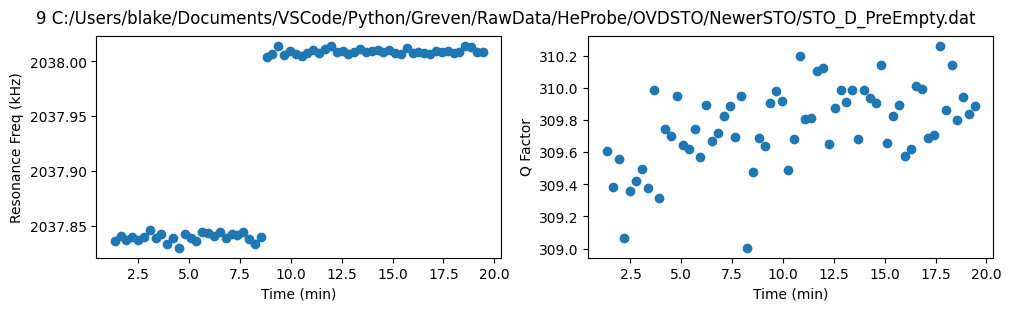

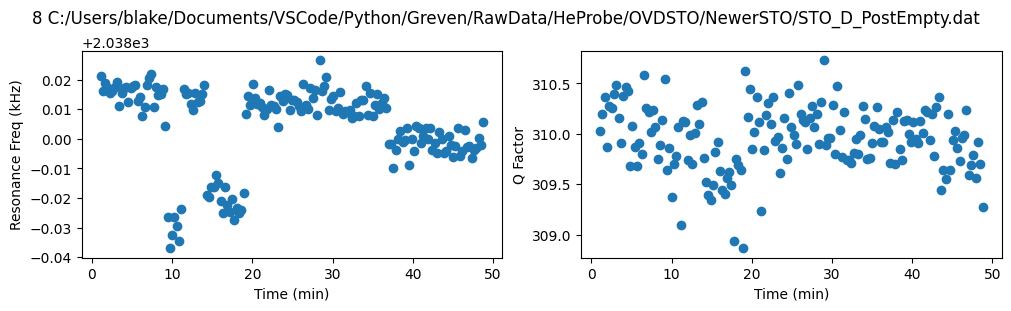

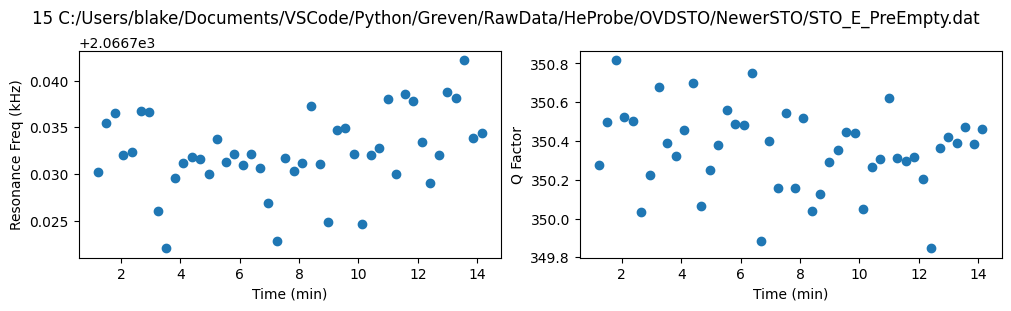

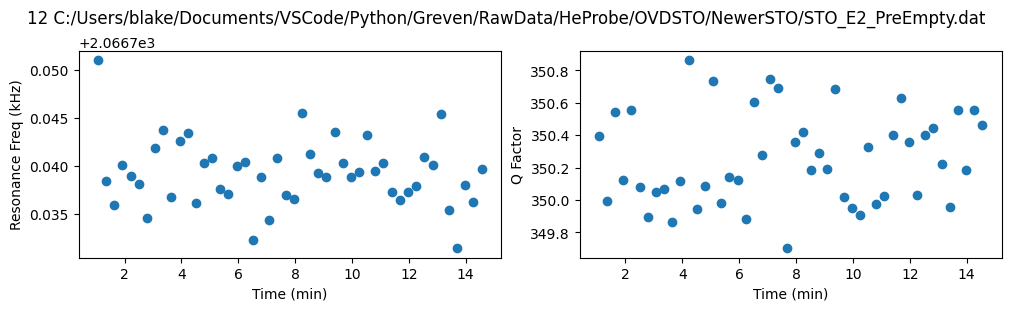

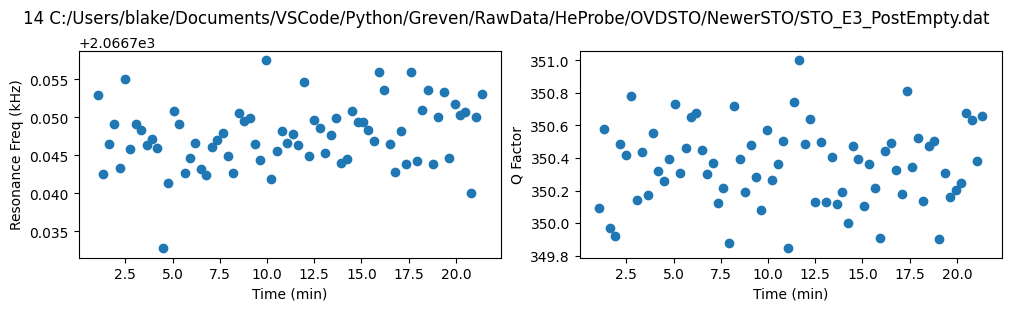

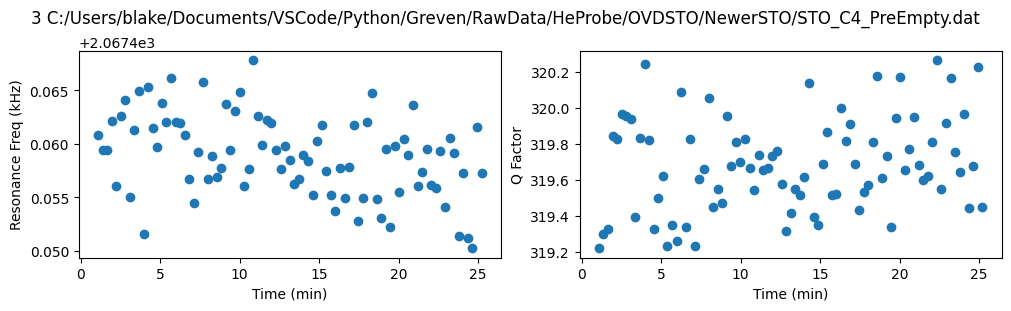

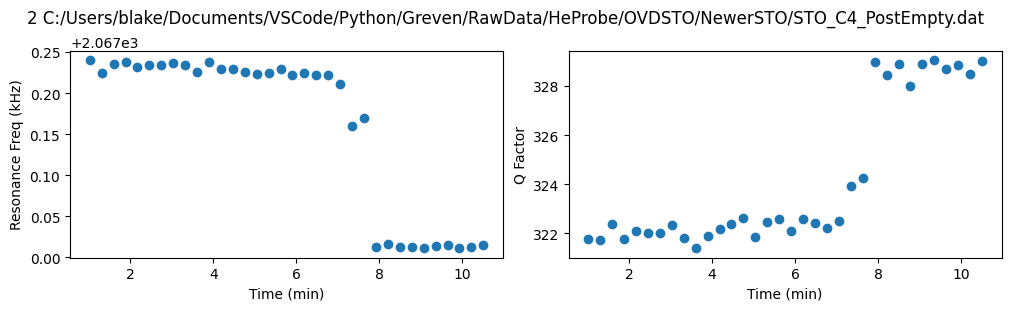

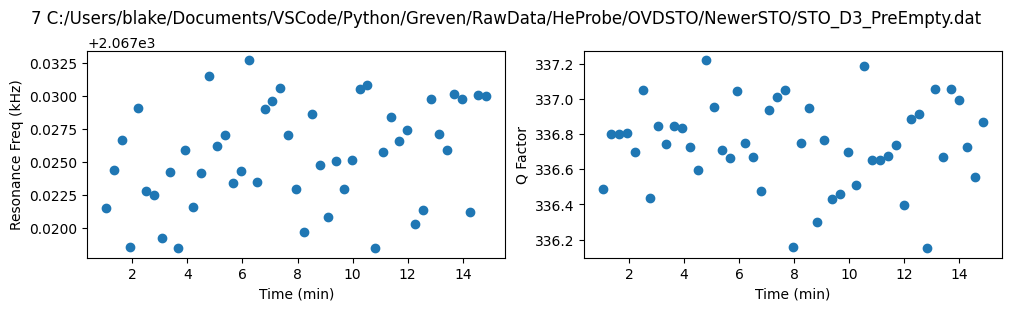

In [4]:
#this part just plots the data, and allows you to explore the measurement to see which timebounds will be appropiate in the future
# print(times[2])

trash_files = [
                # 'C:/Users/blake/Documents/VSCode/Python/Greven/RawData/HeProbe/OVDSTO/DeformedAfterAnnealSTO1.dat',
                # 'C:/Users/blake/Documents/VSCode/Python/Greven/RawData/HeProbe/OVDSTO/DeformedAfterAnnealSTO2.dat',
                # 'C:/Users/blake/Documents/VSCode/Python/Greven/RawData/HeProbe/OVDSTO/DeformedAfterAnnealSTO3.dat',
                # 'C:/Users/blake/Documents/VSCode/Python/Greven/RawData/HeProbe/OVDSTO/DeformedAfterAnnealSTO4.dat',
                # 'C:/Users/blake/Documents/VSCode/Python/Greven/RawData/HeProbe/OVDSTO/DeformedAfterAnnealSTO5.dat',
                # 'C:/Users/blake/Documents/VSCode/Python/Greven/RawData/HeProbe/OVDSTO/DeformedSTO1.dat',
                # 'C:/Users/blake/Documents/VSCode/Python/Greven/RawData/HeProbe/OVDSTO/emptyafterundefored4.dat',
                # 'C:/Users/blake/Documents/VSCode/Python/Greven/RawData/HeProbe/OVDSTO/EmptyfordeformedSTO4.1.dat',
                # 'C:/Users/blake/Documents/VSCode/Python/Greven/RawData/HeProbe/OVDSTO/LowHeCheck.dat',
                # 'C:/Users/blake/Documents/VSCode/Python/Greven/RawData/HeProbe/OVDSTO/sevencapemptytest.dat',
                # 'C:/Users/blake/Documents/VSCode/Python/Greven/RawData/HeProbe/OVDSTO/UndeformedSTO1000mV.dat',
                # 'C:/Users/blake/Documents/VSCode/Python/Greven/RawData/HeProbe/OVDSTO/UndeformedSTO1000mV2.dat',
                # 'C:/Users/blake/Documents/VSCode/Python/Greven/RawData/HeProbe/OVDSTO/UndeformedSTOTest.dat',
                # 'C:/Users/blake/Documents/VSCode/Python/Greven/RawData/HeProbe/OVDSTO/UndeformedSTOTest1.2.dat',
                # 'C:/Users/blake/Documents/VSCode/Python/Greven/RawData/HeProbe/OVDSTO/UndeformedSTOTest1.dat',
                # 'C:/Users/blake/Documents/VSCode/Python/Greven/RawData/HeProbe/OVDSTO/UndeformedSTOTest2.dat'
                # 'C:/Users/blake/Documents/VSCode/Python/Greven/RawData/HeProbe/OVDSTO/STO_D.dat',
                # 'C:/Users/blake/Documents/VSCode/Python/Greven/RawData/HeProbe/OVDSTO/STO_D_Empty.dat',
                # 'C:/Users/blake/Documents/VSCode/Python/Greven/RawData/HeProbe/OVDSTO/STO_Empty2.dat'
               ]

trash_files = [
    'C:/Users/blake/Documents/VSCode/Python/Greven/RawData/HeProbe/OVDSTO/NewerSTO/STO_C3.dat',
    'C:/Users/blake/Documents/VSCode/Python/Greven/RawData/HeProbe/OVDSTO/NewerSTO/STO_C4.dat',
    # 'C:/Users/blake/Documents/VSCode/Python/Greven/RawData/HeProbe/OVDSTO/NewerSTO/STO_C4_PostEmpty.dat',
    # 'C:/Users/blake/Documents/VSCode/Python/Greven/RawData/HeProbe/OVDSTO/NewerSTO/STO_C4_PreEmpty.dat',
    'C:/Users/blake/Documents/VSCode/Python/Greven/RawData/HeProbe/OVDSTO/NewerSTO/STO_D.dat',
    'C:/Users/blake/Documents/VSCode/Python/Greven/RawData/HeProbe/OVDSTO/NewerSTO/STO_D2.dat',
    'C:/Users/blake/Documents/VSCode/Python/Greven/RawData/HeProbe/OVDSTO/NewerSTO/STO_D3.dat',
    # 'C:/Users/blake/Documents/VSCode/Python/Greven/RawData/HeProbe/OVDSTO/NewerSTO/STO_D3_PreEmpty.dat',
    # 'C:/Users/blake/Documents/VSCode/Python/Greven/RawData/HeProbe/OVDSTO/NewerSTO/STO_D_PostEmpty.dat',
    # 'C:/Users/blake/Documents/VSCode/Python/Greven/RawData/HeProbe/OVDSTO/NewerSTO/STO_D_PreEmpty.dat',
    'C:/Users/blake/Documents/VSCode/Python/Greven/RawData/HeProbe/OVDSTO/NewerSTO/STO_E.dat',
    'C:/Users/blake/Documents/VSCode/Python/Greven/RawData/HeProbe/OVDSTO/NewerSTO/STO_E2.dat',
    # 'C:/Users/blake/Documents/VSCode/Python/Greven/RawData/HeProbe/OVDSTO/NewerSTO/STO_E2_PreEmpty.dat',
    'C:/Users/blake/Documents/VSCode/Python/Greven/RawData/HeProbe/OVDSTO/NewerSTO/STO_E3.dat',
    # 'C:/Users/blake/Documents/VSCode/Python/Greven/RawData/HeProbe/OVDSTO/NewerSTO/STO_E3_PostEmpty.dat',
    # 'C:/Users/blake/Documents/VSCode/Python/Greven/RawData/HeProbe/OVDSTO/NewerSTO/STO_E_PreEmpty.dat'
]


# trash_files = files




plt.close('all')
# timebounds = [(0,2000),(0,2000),(0,2000),(0,2000),(0,2000),(0,2000),(0,2000)]
timebounds = [(0,2000)]*len(files)
# timebounds[16] = (0,10)#undeformed1.2
# timebounds[18] = (0,15)#undeformed 2
# timebounds[5] = (0,16)#deformed 1
# timebounds[10] = (8,200)


dates = []
for f in range(len(all_data)):
    dates.append(headings[f][-1][30:])
print(dates)
chrono_order = sort_dates_chronologically(dates)


# for j in range(len(all_data)):
for j in chrono_order:
    print(j,files[j])
    # print(headings[j][-1][30:])
    a = np.average(all_chis[j])
    s = np.std(all_chis[j])
    if not(files[j] in trash_files):
        # print(j)
        # no time bounds
        # fig1 = plt.figure(constrained_layout = True)
        # ax = fig1.add_subplot(2, 1, 1)
        # bx = fig1.add_subplot(2, 1, 2)
        # ax.set_xlabel('Temp (K)')
        # ax.set_ylabel('Resonance Freq (kHz)')
        # bx.set_xlabel('Temp (K)')
        # bx.set_ylabel('Q Factor')
        # ax.scatter(all_temps[j],all_fs[j])
        # bx.scatter(all_temps[j],all_Qs[j])

        # fig2 = plt.figure(constrained_layout = True)
        # cx = fig2.add_subplot(2, 1, 1)
        # dx = fig2.add_subplot(2, 1, 2)
        # cx.set_xlabel('Time (min)')
        # cx.set_ylabel('Resonance Freq (kHz)')
        # dx.set_xlabel('Time (min)')
        # dx.set_ylabel('Q Factor')
        # cx.scatter(all_times[j],all_fs[j])
        # dx.scatter(all_times[j],all_Qs[j])


        #time bounds
        time_inds = np.logical_and(all_times[j] > timebounds[j][0], all_times[j] < timebounds[j][1])
        # print(all_times[j])
        if s != 0:
            chi_inds = np.logical_not((all_chis[j]-a)/s>3)
        else:
            chi_inds = np.logical_not(False)
        time_inds = time_inds & chi_inds

        double = False

        if double:# this shows both temp and time dependance
        
            fig3 = plt.figure(constrained_layout = True, figsize=(8,5))
            ax1 = fig3.add_subplot(2, 2, 1)
            bx1 = fig3.add_subplot(2, 2, 3)
            cx1 = fig3.add_subplot(2, 2, 2)
            dx1 = fig3.add_subplot(2, 2, 4)
            ax1.set_xlabel('Temp (K)')
            ax1.set_ylabel('Resonance Freq (kHz)')
            bx1.set_xlabel('Temp (K)')
            bx1.set_ylabel('Q Factor')
            ax1.scatter(all_temps[j][time_inds],all_fs[j][time_inds])
            bx1.scatter(all_temps[j][time_inds],all_Qs[j][time_inds])  
            cx1.set_xlabel('Time (min)')
            cx1.set_ylabel('Resonance Freq (kHz)')
            dx1.set_xlabel('Time (min)')
            dx1.set_ylabel('Q Factor')
            cx1.scatter(all_times[j][time_inds],all_fs[j][time_inds])
            dx1.scatter(all_times[j][time_inds],all_Qs[j][time_inds])
            fig3.suptitle(files[j])
        else:
            fig3 = plt.figure(constrained_layout = True, figsize=(10,3))
            ax1 = fig3.add_subplot(1, 2, 1)
            bx1 = fig3.add_subplot(1, 2, 2)
            ax1.set_xlabel('Time (min)')
            ax1.set_ylabel('Resonance Freq (kHz)')
            bx1.set_ylabel('Q Factor')
            bx1.set_xlabel('Time (min)')
            ax1.scatter(all_times[j][time_inds],all_fs[j][time_inds])
            bx1.scatter(all_times[j][time_inds],all_Qs[j][time_inds])
            fig3.suptitle(str(j)+' '+files[j])


        # fig4 = plt.figure(constrained_layout = True)
        # ax2 = fig4.add_subplot(1, 1, 1)
        # ax2.set_xlabel('Time (min)')
        # ax2.set_ylabel('Temp (K)')
        # ax2.scatter(all_times[j][time_inds],all_temps[j][time_inds])

Find Empties

[[309.87979377449733, 310.1437561877658], [350.3576321871714, 350.25052844689145], [350.25052844689145, 350.35538371360576], [322.13334805444293, 322.13334805444293], [336.74281320925485, 336.74281320925485]] [[0.18693410635959679, 0.24950184070032613], [0.20868174625124297, 0.2798368881713453], [0.2798368881713453, 0.2439635089027971], [0.3265264388065696, 0.3265264388065696], [0.2404682529794397, 0.2404682529794397]]
[[2038.0091618857498, 2038.0161862669647], [2066.732305098531, 2066.7392170219505], [2066.7392170219505, 2066.7476159447883], [2067.2299888947896, 2067.2299888947896], [2067.025471353635, 2067.025471353635]] [[0.002023072705830215, 0.0034597589305545304], [0.004206132540614007, 0.003455766578758686], [0.003455766578758686, 0.004206071574675157], [0.005937886924370523, 0.005937886924370523], [0.003846529417036861, 0.003846529417036861]]


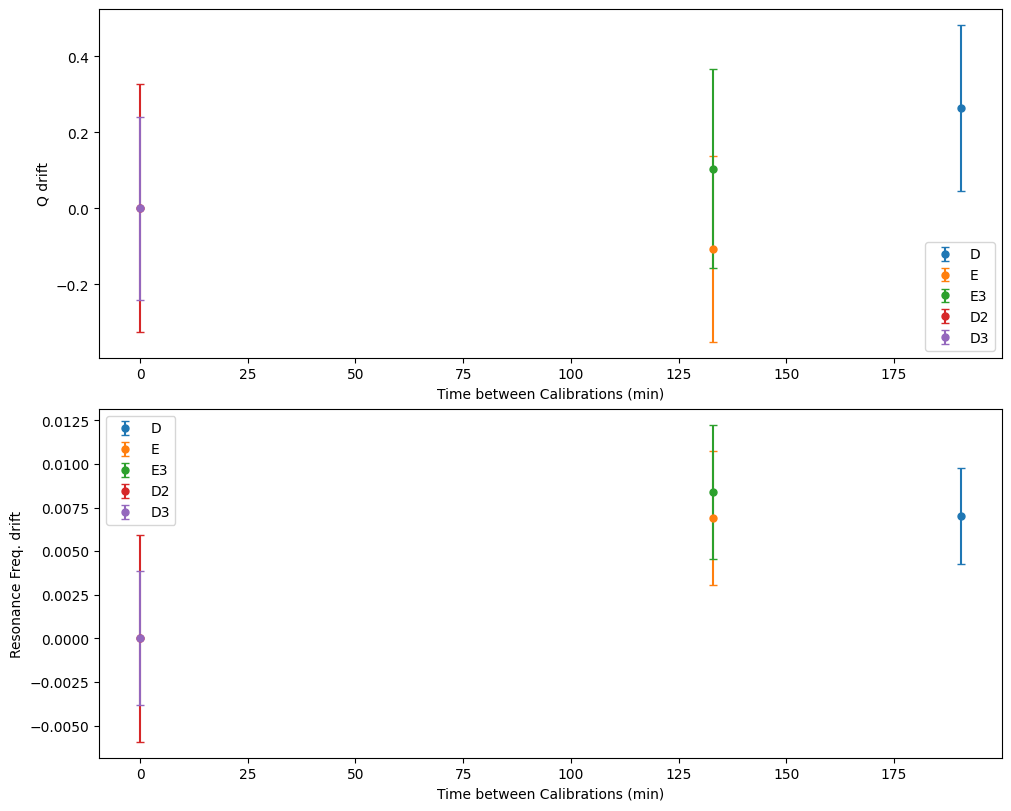

In [5]:
# this is where you define the conactless measurements that will be used later for the calibration


# empty_file_inds = [18,5]
#(0,72), this is for undeofrmed sto 1.2
# measure_times = [(0,147),(2,150)] for undeformed and deformed STO:#undeformed 2, deformed 1
# empty_file_inds = [11]
empty_file_inds = [(9,8),(15,12),(12,14),(2,2),(7,7)]
empty_times = [((10,100),(0,8)),((0,100),(0,100)),((0,100),(0,100)),((0,7),(0,7)),((0,100),(0,100))]
measure_file_inds = [4,10,13,5,6]#STO_D, STO_E, STO_E3, STO_D2, STO_D3


emptyQs = []
empty_res = []
Q_resolutions = []
f_resolutions = []

fig = plt.figure(constrained_layout = True, figsize=(10,8))
ax = fig.add_subplot(2, 1, 1)
bx = fig.add_subplot(2, 1, 2)

for i in range(len(empty_file_inds)):
    
    emptyQs.append([])
    empty_res.append([])
    Q_resolutions.append([])
    f_resolutions.append([])
    for k, j in enumerate(empty_file_inds[i]):# k will only ever be 0 and 1, which allows for the empty measure times differences
        inds = np.logical_and(all_times[j]>empty_times[i][k][0], all_times[j]<empty_times[i][k][1])
        emptyQs[i].append(np.average(all_Qs[j][inds]))
        empty_res[i].append(np.average(all_fs[j][inds]))
        Q_resolutions[i].append(np.std(all_Qs[j][inds]))
        f_resolutions[i].append(np.std(all_fs[j][inds]))
    time_dif = get_time_diff(dates[empty_file_inds[i][0]],dates[empty_file_inds[i][1]])
    ax.errorbar(time_dif,emptyQs[i][1]-emptyQs[i][0],np.average(Q_resolutions[i]),
                marker='o', capsize=3,ms = 5,ls='none',
                label = files[measure_file_inds[i]].split('/')[-1][4:-4])
    bx.errorbar(time_dif,empty_res[i][1]-empty_res[i][0],np.average(f_resolutions[i]),
                marker='o', capsize=3,ms = 5,ls='none',
                label = files[measure_file_inds[i]].split('/')[-1][4:-4])
    
ax.set_ylabel('Q drift')
bx.set_ylabel('Resonance Freq. drift')
ax.set_xlabel('Time between Calibrations (min)')
bx.set_xlabel('Time between Calibrations (min)')
ax.legend()
bx.legend()
print(emptyQs,Q_resolutions)
print(empty_res,f_resolutions)

Simulate Mu from Contacted Measurement

12804874.909264073 0.001399 0.001056
12985308.335599639 0.00126 0.00108
12985301.252225634 0.00126 0.00108
12986660.842803976 0.001399 0.001056
12904152.532212242 0.001399 0.001056


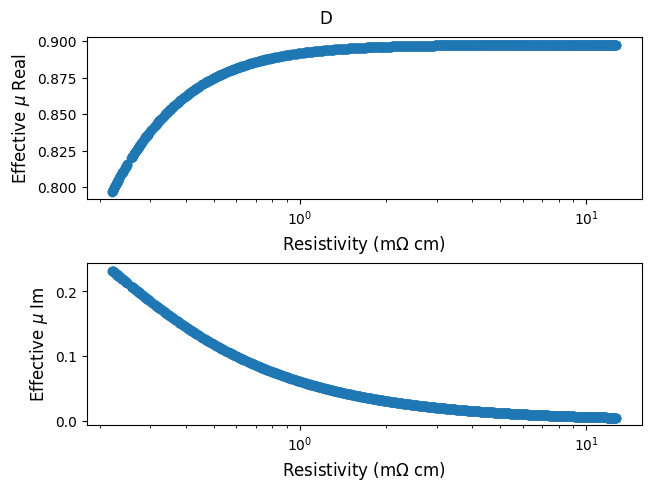

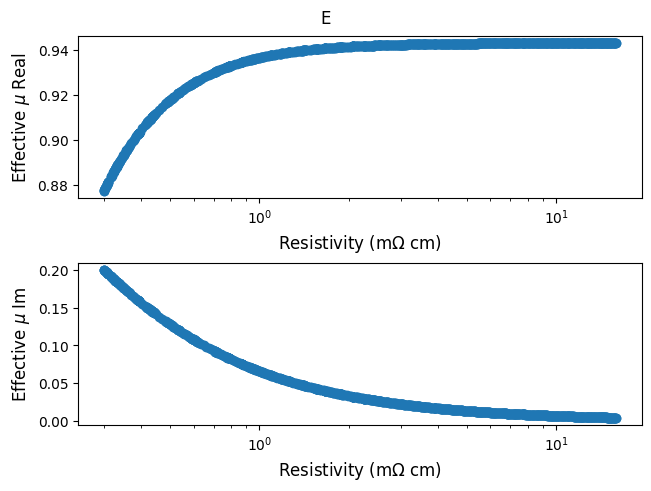

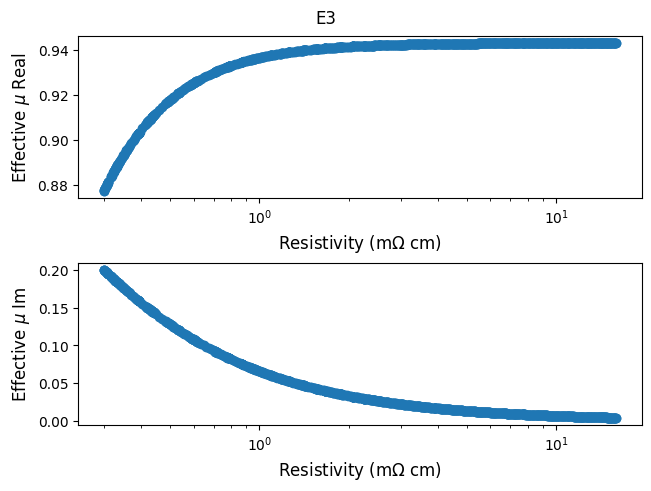

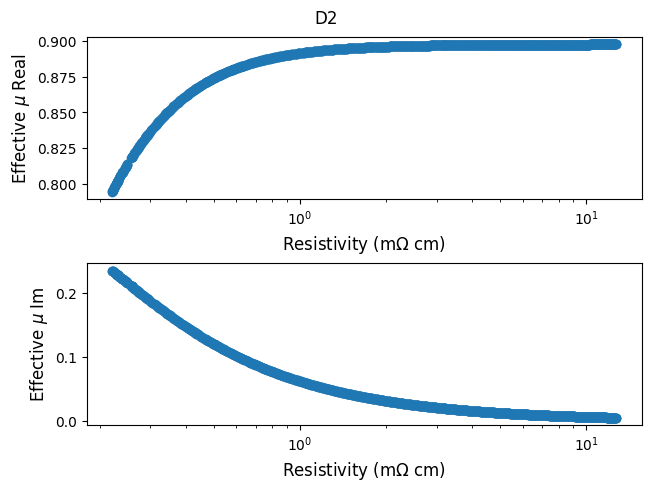

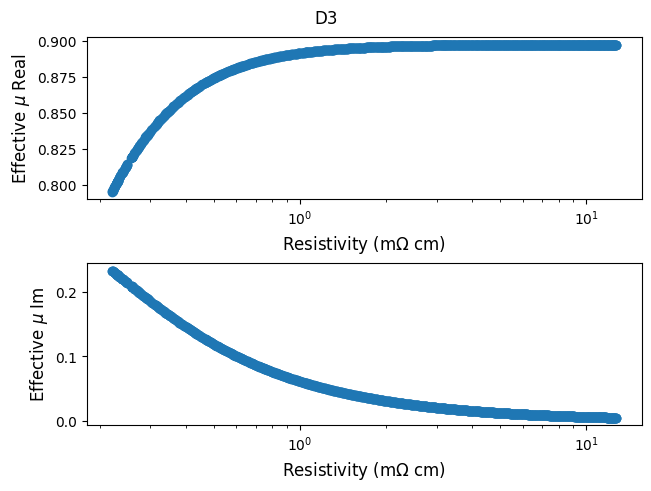

In [6]:
#the goal of this section is to start to connect the contacted resisivity measurements to each of the contactless measurements

omegas = np.zeros(len(measure_file_inds))
for j, ind in enumerate(measure_file_inds):
    omegas[j] = np.average(all_fs[ind])*1000*2*np.pi

t_num =1000 #resolution of the temps
Ts = np.array([np.linspace(4,150,t_num)]*len(measure_file_inds))#temperatures at will be simulated for each resistivity profile
mus = np.zeros((len(Ts),t_num),dtype=np.complex128)

contacted_inds = [0, 1, 1, 0,0]

res_coef = np.array([1]*len(Ts))
mu_0 = 4*np.pi*1e-7
act_mus = []
temp_inds = []
temp_bounds = [(4,100)]*len(measure_file_inds)
temp_bounds[0] = (4,150)
# print(resistivities[i])
# resistivities[0][1] = resistivities[0][2]
# print(resistivities[i])


for i in range(len(Ts)):

    rhos = np.interp(Ts[i],split_temps[contacted_inds[i]],res_coef[i]*resistivities3[contacted_inds[i]])

    for k, rho in enumerate(rhos):
        mus[i][k] = calc_mu(omegas[i],rho,rho,lengths[contacted_inds[i]],widths[contacted_inds[i]])
    area = lengths[contacted_inds[i]]*widths[contacted_inds[i]]


    # if copying the paper:
    # fig4 = plt.figure(constrained_layout = True)
    # ax1 = fig4.add_subplot(2, 1, 1)
    # ax2 = fig4.add_subplot(2, 1, 2)
    # ax1.set_xlabel(r'$\frac{\omega \mu_0 a^2}{\rho}$',fontsize = 12)
    # ax1.set_ylabel(r'Effective $\mu$ Real',fontsize = 12)
    # ax1.scatter(mu_0*omegas[i]*area/rhos,np.real(mus[i]),label = 'Real Part')
    # ax2.set_xlabel(r'$\frac{\omega \mu_0 a^2}{\rho}$',fontsize = 12)
    # ax2.set_ylabel(r'Effective $\mu$ Im',fontsize = 12)
    # ax2.scatter(mu_0*omegas[i]*area/rhos,np.abs(np.imag(mus[i])),label = 'Imaginary Part')

    #if looking at ressiitiity
    fig5 = plt.figure(constrained_layout = True)
    ax3 = fig5.add_subplot(2, 1, 1)
    ax4 = fig5.add_subplot(2, 1, 2)
    ax3.set_xlabel(r'Resistivity (m$\Omega$ cm)',fontsize = 12)
    ax3.set_ylabel(r'Effective $\mu$ Real',fontsize = 12)
    ax3.scatter(rhos*1e5,np.real(mus[i]),label = 'Real Part')
    ax4.set_xlabel(r'Resistivity (m$\Omega$ cm)',fontsize = 12)
    ax4.set_ylabel(r'Effective $\mu$ Im',fontsize = 12)
    ax4.scatter(rhos*1e5,np.abs(np.imag(mus[i])),label = 'Imaginary Part')
    ax3.set_xscale('log')
    ax4.set_xscale('log')
    fig5.suptitle(files[measure_file_inds[i]].split('/')[-1][4:-4])


    #Calcualte the expected mu for each temperature from the contacted resisitiivity
    temp_inds.append(np.logical_and(split_temps[contacted_inds[i]] > temp_bounds[i][0], split_temps[contacted_inds[i]] < temp_bounds[i][1])) #logical and operation
    act_mus.append(np.zeros(len(split_temps[contacted_inds[i]][temp_inds[i]]),dtype=np.complex128))
    print(omegas[i],lengths[contacted_inds[i]],widths[contacted_inds[i]])
    for k, rho in enumerate(res_coef[i]*resistivities3[contacted_inds[i]][temp_inds[i]]):
        act_mus[i][k] = calc_mu(omegas[i],rho,rho,lengths[contacted_inds[i]],widths[contacted_inds[i]])

Plot Simulation and data

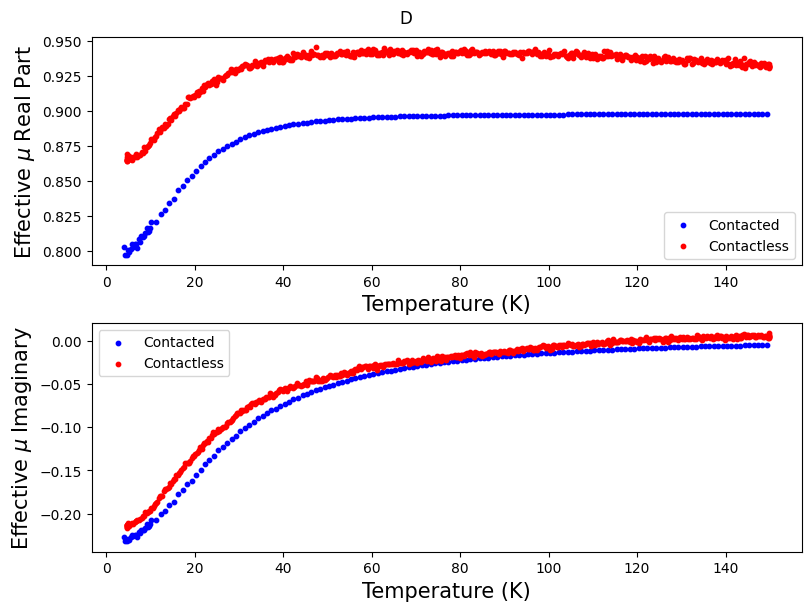

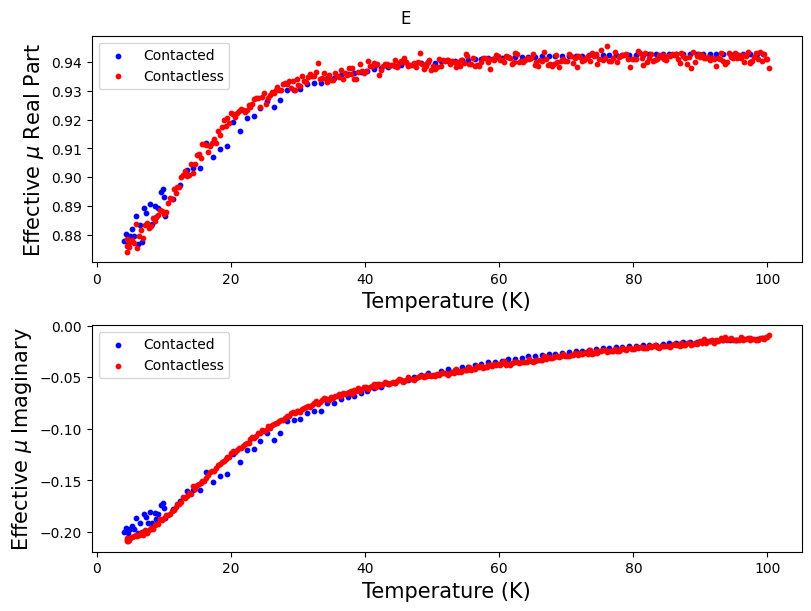

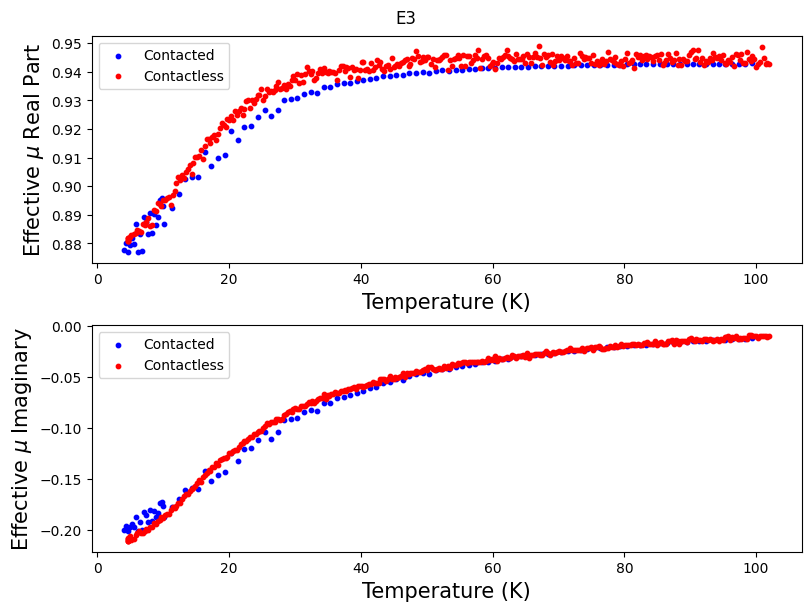

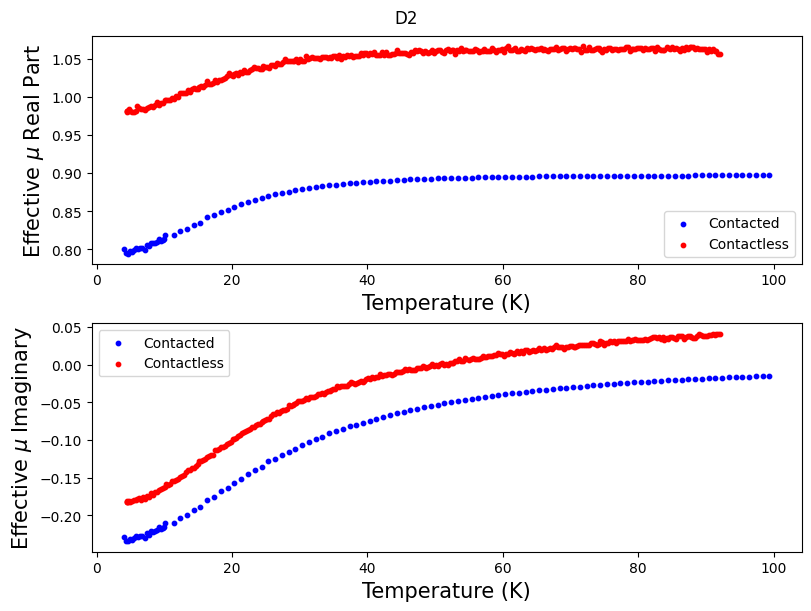

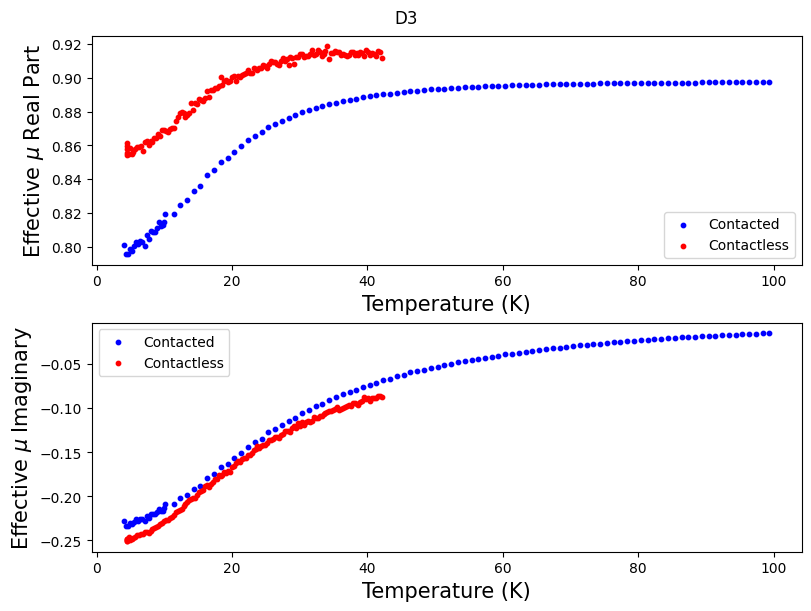

In [7]:
offset_parameters = []
for i in range(len(measure_file_inds)):
    offset_parameters.append([[0.90639874, -0.41431875],[ 8.72344294e-03, -4.99622889e+02]]) #[[freqeuency],[Q factor]] (inside each[y offset,scaling but centered around 1 instead of 0])
Q_bounds = [[0,500]]*len(measure_file_inds)
measure_times = [(0,300)]*len(measure_file_inds)

measure_times[0] = (8,200)
measure_times[3] = (0,90)
measure_times[4] = (0,40)
for j, ind in enumerate(measure_file_inds):
    a = np.average(all_chis[ind])
    s = np.std(all_chis[ind])

    #filter out points with bad fits and outside the measure times
    time_inds = np.logical_and(all_times[ind] > measure_times[j][0], all_times[ind] < measure_times[j][1])
    chi_inds = np.logical_not((all_chis[ind]-a)/s>3)
    Q_inds = np.logical_and(all_Qs[ind] > Q_bounds[j][0], all_Qs[ind] < Q_bounds[j][1])
    time_inds = time_inds & chi_inds #logical and operation
    time_inds = time_inds & Q_inds

    fig = plt.figure(constrained_layout = True,figsize=(8,6))
    ax1 = fig.add_subplot(2, 1, 1)
    ax2 = fig.add_subplot(2, 1, 2)
    # ax1a = ax1.twinx()
    # ax2a = ax2.twinx()


    ax1.scatter(split_temps[contacted_inds[j]][temp_inds[j]],np.real(act_mus[j]),label = 'Contacted',c='blue',s=10)

    ax1.scatter(all_temps[ind][time_inds],
                offset_parameters[j][0][0] + offset_parameters[j][0][1] * (all_fs[ind][time_inds]-np.average(empty_res[j])),
                c='red',s=10,label = 'Contactless')
    
    ax2.scatter(split_temps[contacted_inds[j]][temp_inds[j]],np.imag(act_mus[j]),label = 'Contacted',c='blue',s=10)

    ax2.scatter(all_temps[ind][time_inds],
                offset_parameters[j][1][0] + offset_parameters[j][1][1] * (1/np.array(all_Qs[ind][time_inds])-1/np.average(emptyQs[j])),
                c='red',s=10,label = 'Contactless')
    
    #aesthetic
    ax2.set_xlabel('Temperature (K)',fontsize = 15)
    ax2.set_ylabel(r'Effective $\mu$ Imaginary',fontsize = 15)
    ax1.set_xlabel('Temperature (K)',fontsize = 15)
    ax1.set_ylabel(r'Effective $\mu$ Real Part',fontsize = 15)
    fig.suptitle(files[measure_file_inds[j]].split('/')[-1][4:-4])
    ax1.legend()
    ax2.legend()

Resistivity changing Fitting Calibration Parameters

In [8]:
def objective(params, res_temps, contactless_Ts, resistivities,length,width,fs,empty_f,Qs,empty_Q,omega,act_mus4,fit_res = True):
    if fit_res:
        a, b, c, d, res_coef = params

        #calculate mus first from contacted data
        act_mus3 = np.zeros(len(contactless_Ts),dtype=np.complex128)
        rhos = np.interp(contactless_Ts,res_temps,res_coef*resistivities)

        for k, rho in enumerate(rhos):
            act_mus3[k] = calc_mu(omega,rho,rho,length,width)

        
        contactless_mu_real = a + b * (fs-np.average(empty_f))
        contactless_mu_img = c + d * (1/Qs-1/np.average(empty_Q))
        s1 = np.sum((1 - contactless_mu_real/np.real(act_mus3)) ** 2)
        s2 = np.sum((1 - contactless_mu_img/np.imag(act_mus3)) ** 2)
        s3 = np.sum((1 - np.real(act_mus3)/contactless_mu_real) ** 2)
        s4 = np.sum((1 - np.imag(act_mus3)/contactless_mu_img) ** 2)
        return  np.sum((s1,s2,s3,s4))
    else:
        a, b, c, d, res_coef = params
        contactless_mu_real = a + b * (fs-np.average(empty_f))
        contactless_mu_img = c + d * (1/Qs-1/np.average(empty_Q))
        s1 = np.sum((1 - contactless_mu_real/np.real(act_mus4)) ** 2)
        s2 = np.sum((1 - contactless_mu_img/np.imag(act_mus4)) ** 2)
        s3 = np.sum((1 - np.real(act_mus4)/contactless_mu_real) ** 2)
        s4 = np.sum((1 - np.imag(act_mus4)/contactless_mu_img) ** 2)
        return  np.sum((s1,s2,s3,s4))
# print(len(act_mus))
initial_guesses = []
for para in offset_parameters:
    initial_guesses.append([para[0][0],para[0][1],para[1][0],para[1][1],1])
fitted_parameters = []
fitted_parameters2 = []



mus2 = []
for j, ind in enumerate(measure_file_inds):
    time_inds = np.logical_and(all_times[ind] > measure_times[j][0], all_times[ind] < measure_times[j][1])
    chi_inds = np.logical_not((all_chis[ind]-a)/s>3)
    Q_inds = np.logical_and(all_Qs[ind] > Q_bounds[j][0], all_Qs[ind] < Q_bounds[j][1])
    time_inds = time_inds & chi_inds #logical and operation
    time_inds = time_inds & Q_inds


    rhos = np.interp(all_temps[ind][time_inds],split_temps[contacted_inds[j]],resistivities3[contacted_inds[j]])
    mus2.append(np.zeros(len(all_temps[ind][time_inds]),dtype=np.complex128))
    for k, rho in enumerate(rhos):
        mus2[j][k] = calc_mu(omegas[j],rho,rho,lengths[contacted_inds[j]],widths[contacted_inds[j]])




for j, ind in enumerate(measure_file_inds):

    time_inds = np.logical_and(all_times[ind] > measure_times[j][0], all_times[ind] < measure_times[j][1])
    chi_inds = np.logical_not((all_chis[ind]-a)/s>3)
    Q_inds = np.logical_and(all_Qs[ind] > Q_bounds[j][0], all_Qs[ind] < Q_bounds[j][1])
    time_inds = time_inds & chi_inds #logical and operation
    time_inds = time_inds & Q_inds

    # Perform the optimization
    result = optimize.minimize(objective, initial_guesses[j], 
                                bounds= [(-1,1),(-1e5,1e5),(-1,1),(-1e5,1e5),(1e-2,1e2)],
                                args=(split_temps[contacted_inds[j]][temp_inds[j]], 
                                all_temps[ind][time_inds],
                                resistivities3[contacted_inds[j]][temp_inds[j]],
                                lengths[contacted_inds[j]],
                                widths[contacted_inds[j]],
                                all_fs[ind][time_inds],
                                empty_res[j],
                                np.array(all_Qs[ind][time_inds]),
                                emptyQs[j],
                                omegas[j],
                                mus2[j],
                                True))#this controls whether or not the resisitivity is allowed to be fitted as well

    # Extract the fitting parameters
    a_fit, b_fit, c_fit, d_fit, res_coef_fit= result.x
    print(result.x)
    fitted_parameters.append(result.x)

    result = optimize.minimize(objective, initial_guesses[j], 
                                bounds= [(-1,1),(-1e5,1e5),(-1,1),(-1e5,1e5),(1e-2,1e2)],
                                args=(split_temps[contacted_inds[j]][temp_inds[j]], 
                                all_temps[ind][time_inds],
                                resistivities3[contacted_inds[j]][temp_inds[j]],
                                lengths[contacted_inds[j]],
                                widths[contacted_inds[j]],
                                all_fs[ind][time_inds],
                                empty_res[j],
                                np.array(all_Qs[ind][time_inds]),
                                emptyQs[j],
                                omegas[j],
                                mus2[j],
                                False))#this controls whether or not the resisitivity is allowed to be fitted as well

    # Extract the fitting parameters
    a_fit, b_fit, c_fit, d_fit, res_coef_fit= result.x
    print(result.x)
    fitted_parameters2.append(result.x)

    print(objective(initial_guesses[j],split_temps[contacted_inds[j]][temp_inds[j]], 
                                all_temps[ind][time_inds],
                                resistivities3[contacted_inds[j]][temp_inds[j]],
                                lengths[contacted_inds[j]],
                                widths[contacted_inds[j]],
                                all_fs[ind][time_inds],
                                empty_res[j],
                                np.array(all_Qs[ind][time_inds]),
                                emptyQs[j],
                                omegas[j],
                                True))
    print(objective(fitted_parameters[j],split_temps[contacted_inds[j]][temp_inds[j]], 
                                all_temps[ind][time_inds],
                                resistivities3[contacted_inds[j]][temp_inds[j]],
                                lengths[contacted_inds[j]],
                                widths[contacted_inds[j]],
                                all_fs[ind][time_inds],
                                empty_res[j],
                                np.array(all_Qs[ind][time_inds]),
                                emptyQs[j],
                                omegas[j],
                                True))
    print(objective(fitted_parameters2[j],split_temps[contacted_inds[j]][temp_inds[j]], 
                                all_temps[ind][time_inds],
                                resistivities3[contacted_inds[j]][temp_inds[j]],
                                lengths[contacted_inds[j]],
                                widths[contacted_inds[j]],
                                all_fs[ind][time_inds],
                                empty_res[j],
                                np.array(all_Qs[ind][time_inds]),
                                emptyQs[j],
                                omegas[j],
                                True))


[ 8.93798669e-01 -4.11493725e-01  1.56245762e-02 -1.14469700e+03
  1.64850030e+00]
[ 8.83373896e-01 -4.10119460e-01  1.99431446e-02 -1.70123936e+03
  1.00000000e+00]
628528.943052848
4817.866960975763
4128.5194561626995
[ 9.06056465e-01 -4.17737624e-01  9.34023535e-03 -4.99623045e+02
  9.94090035e-01]
[ 9.06396253e-01 -4.14316032e-01  9.46934459e-03 -4.99622821e+02
  1.00000000e+00]
5.494657302857539
4.946785160441822
4.955329857528669
[ 9.03342881e-01 -4.13993722e-01  7.93409555e-03 -4.99622959e+02
  1.02569410e+00]
[ 9.02780307e-01 -4.13650372e-01  7.47292065e-03 -4.99623223e+02
  1.00000000e+00]
4.826233942095619
2.7597418483975904
2.9074563857314035
[ 9.99999997e-01  3.07578361e-01  6.81027516e-03 -3.79551500e+02
  5.04964425e+00]
[-7.07102966e-01  5.00036986e-01  4.67768920e-02  4.86685829e+02
  1.00000000e+00]
110456.78975444952
8900.82447928637
4980.423642657042
[ 8.91592325e-01 -1.55065663e-01  1.98035392e-02 -2.76006337e+02
  2.16854439e+00]
[ 8.70537038e-01 -6.19441603e-01  2

Constant Resistivity Fitting

In [9]:
mus2 = []
mu_infs = np.zeros(len(measure_file_inds),dtype=np.complex128)
for j, ind in enumerate(measure_file_inds):
    time_inds = np.logical_and(all_times[ind] > measure_times[j][0], all_times[ind] < measure_times[j][1])
    chi_inds = np.logical_not((all_chis[ind]-a)/s>3)
    Q_inds = np.logical_and(all_Qs[ind] > Q_bounds[j][0], all_Qs[ind] < Q_bounds[j][1])
    time_inds = time_inds & chi_inds #logical and operation
    time_inds = time_inds & Q_inds

    
    mu_infs[j] = calc_mu(omegas[j],1,1,lengths[contacted_inds[j]],widths[contacted_inds[j]])
    rhos = np.interp(all_temps[ind][time_inds],split_temps[contacted_inds[j]],resistivities3[contacted_inds[j]])
    mus2.append(np.zeros(len(all_temps[ind][time_inds]),dtype=np.complex128))
    for k, rho in enumerate(rhos):
        mus2[j][k] = calc_mu(omegas[j],rho,rho,lengths[contacted_inds[j]],widths[contacted_inds[j]])

real_guesses = []
imag_guesses = []
for para in offset_parameters:
    real_guesses.append([para[0][0],para[0][1]])
    imag_guesses.append([para[1][0],para[1][1]])
pbounds1 = np.array([(-1,-1e5),(1,1e5)]) # [[Lower bounds],[upper bounds]]

bestpars_real = []
bestpars_imag = []

for j, ind in enumerate(measure_file_inds):

    def real_comp(fs,a,b):
        return a + b * (fs-np.average(empty_res[j]))
    def imag_comp(Qs,c,d):
        return c + d * (1/Qs-1/np.average(emptyQs[j]))
    
    time_inds = np.logical_and(all_times[ind] > measure_times[j][0], all_times[ind] < measure_times[j][1])
    chi_inds = np.logical_not((all_chis[ind]-a)/s>3)
    Q_inds = np.logical_and(all_Qs[ind] > Q_bounds[j][0], all_Qs[ind] < Q_bounds[j][1])
    time_inds = time_inds & chi_inds #logical and operation
    time_inds = time_inds & Q_inds

    bestfit_real = optimize.curve_fit(real_comp,all_fs[ind][time_inds],np.real(mus2[j]),real_guesses[j], bounds=pbounds1)
    bestpars_real.append(bestfit_real[0])
    bestfit_imag = optimize.curve_fit(imag_comp,np.array(all_Qs[ind][time_inds]),np.imag(mus2[j]),imag_guesses[j], bounds=pbounds1)
    bestpars_imag.append(bestfit_imag[0])
    print(bestfit_real[0],bestfit_imag[0])


[ 0.85265504 -0.53140216] [ 1.21986012e-03 -5.37581960e+02]
[ 0.90639874 -0.41431875] [ 8.72344294e-03 -4.99622889e+02]
[ 0.90228211 -0.42112628] [ 5.05211107e-03 -4.87843820e+02]
[ 0.70721125 -0.49972238] [-4.67908641e-02 -4.97945438e+02]
[ 0.87061635 -0.62190656] [ 1.98099933e-02 -4.95511156e+02]


Check Fit

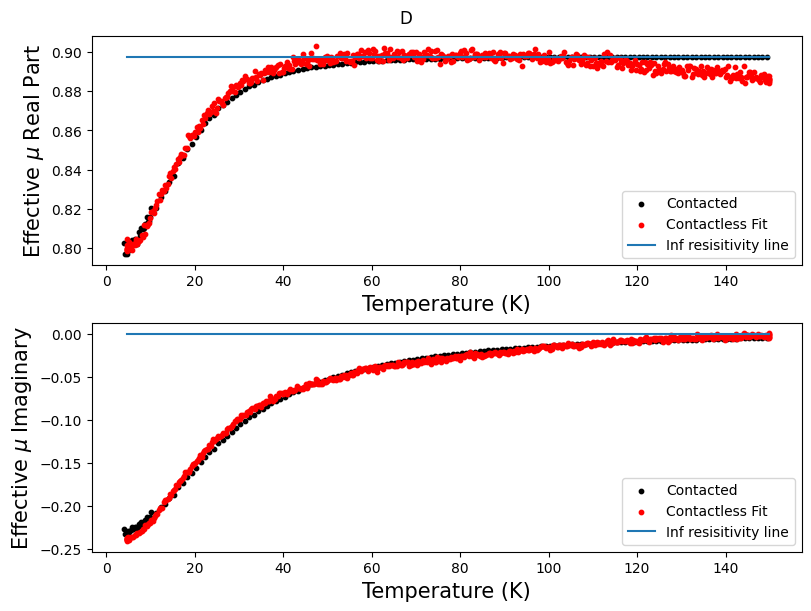

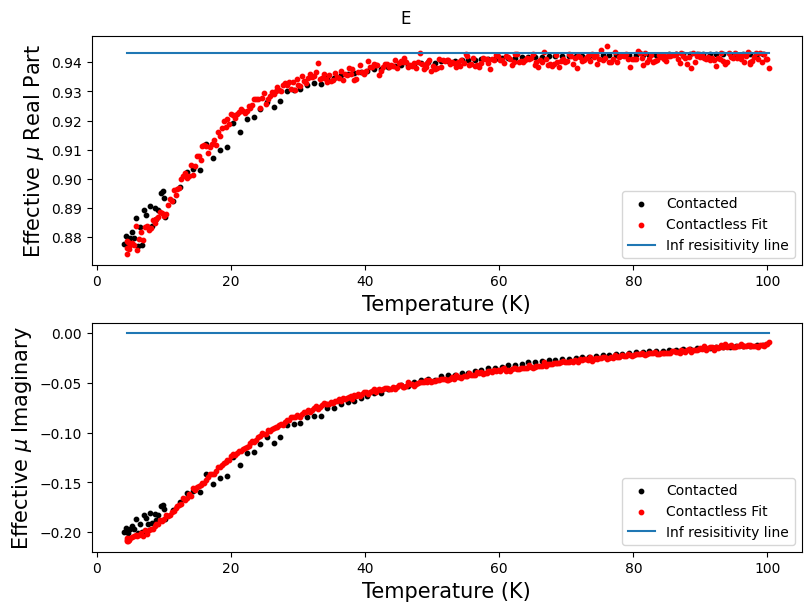

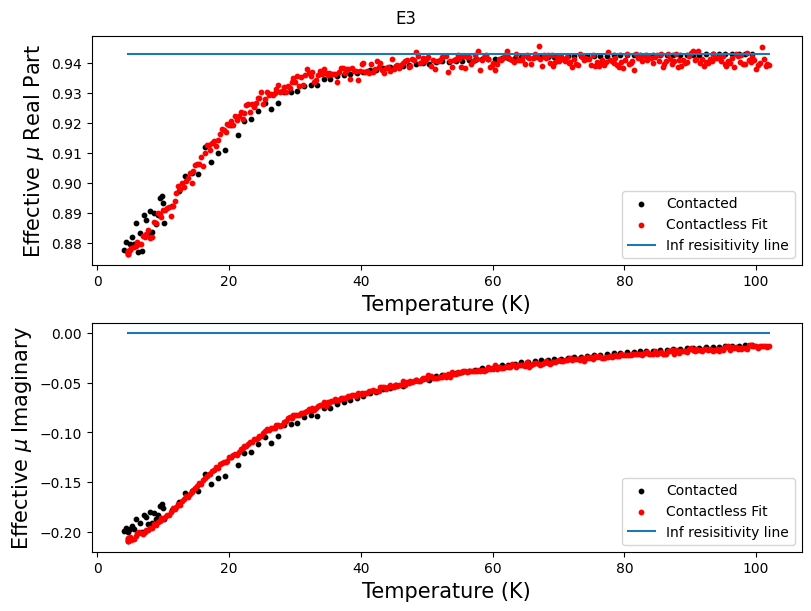

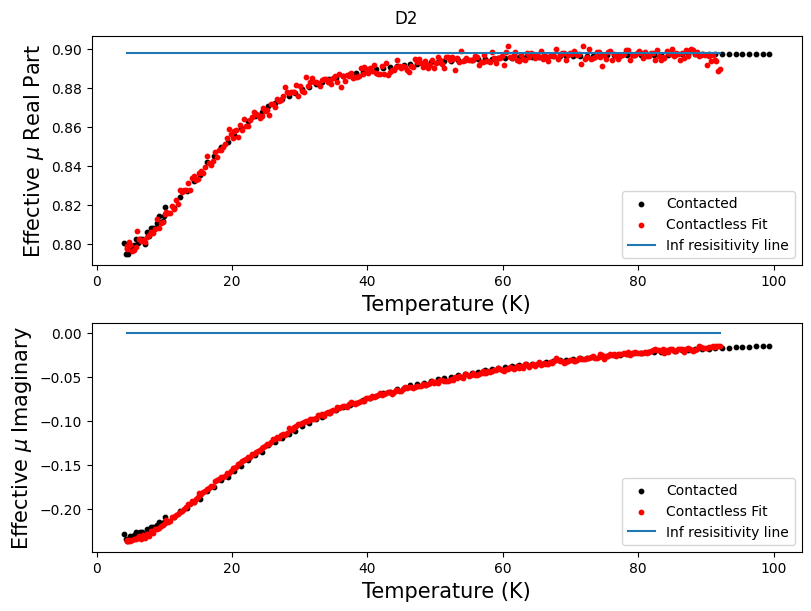

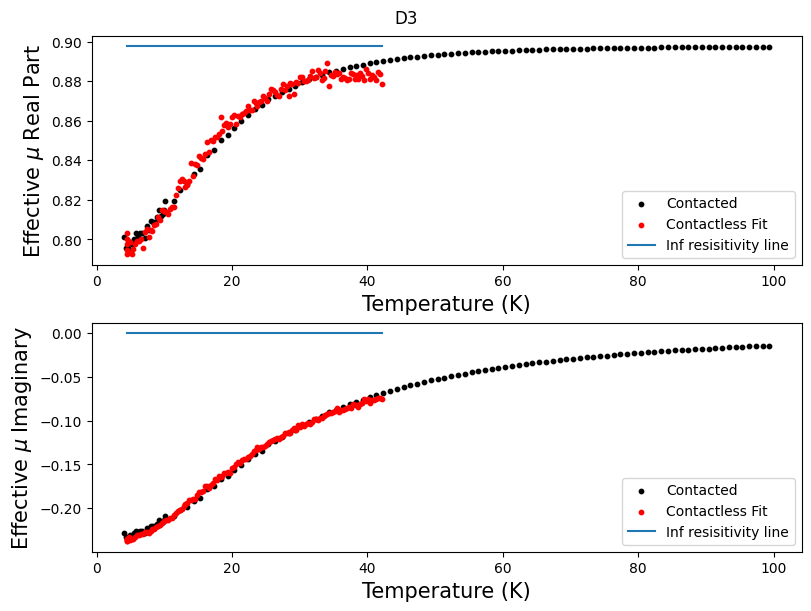

In [10]:
act_mus2 = []
for j, ind in enumerate(measure_file_inds):
    
    for i in range(len(Ts)):
        #Calcualte the expected mu for each temperature from the contacted resisitiivity
        act_mus2.append(np.zeros(len(split_temps[contacted_inds[i]][temp_inds[i]]),dtype=np.complex128))
        for k, rho in enumerate(resistivities3[contacted_inds[i]][temp_inds[i]]):
            act_mus2[i][k] = calc_mu(omegas[i],rho,rho,lengths[contacted_inds[i]],widths[contacted_inds[i]])


for j, ind in enumerate(measure_file_inds):
    a = np.average(all_chis[ind])
    s = np.std(all_chis[ind])

    #filter out points with bad fits and outside the measure times
    time_inds = np.logical_and(all_times[ind] > measure_times[j][0], all_times[ind] < measure_times[j][1])
    chi_inds = np.logical_not((all_chis[ind]-a)/s>3)
    Q_inds = np.logical_and(all_Qs[ind] > Q_bounds[j][0], all_Qs[ind] < Q_bounds[j][1])
    time_inds = time_inds & chi_inds #logical and operation
    time_inds = time_inds & Q_inds

    fig = plt.figure(constrained_layout = True,figsize=(8,6))
    ax1 = fig.add_subplot(2, 1, 1)
    ax2 = fig.add_subplot(2, 1, 2)
    
    ax1.scatter(split_temps[contacted_inds[j]][temp_inds[j]],np.real(act_mus[j]),label = 'Contacted',c='black',s=10)

    # ax1.scatter(all_temps[ind][time_inds],
    #             fitted_parameters[j][0] + fitted_parameters[j][1] * (all_fs[ind][time_inds]-np.average(empty_res[j])),
    #             c='green',s=10,label = 'Contactless')
    ax1.scatter(all_temps[ind][time_inds],
                bestpars_real[j][0] + bestpars_real[j][1] * (all_fs[ind][time_inds]-np.average(empty_res[j])),
                c='red',s=10,label = 'Contactless Fit')
                
    
    
    
    ax2.scatter(split_temps[contacted_inds[j]][temp_inds[j]],np.imag(act_mus[j]),label = 'Contacted',c='black',s=10)

    # ax2.scatter(all_temps[ind][time_inds],
    #             fitted_parameters[j][2] + fitted_parameters[j][3] * (1/np.array(all_Qs[ind][time_inds])-1/np.average(emptyQs[j])),
    #             c='green',s=10,label = 'Contactless')
    
    ax2.scatter(all_temps[ind][time_inds],
                bestpars_imag[j][0] + bestpars_imag[j][1] * (1/np.array(all_Qs[ind][time_inds])-1/np.average(emptyQs[j])),
                c='red',s=10,label = 'Contactless Fit')
    
    ax1.plot([min(all_temps[ind][time_inds]),max(all_temps[ind][time_inds])],np.ones(2)*np.real(mu_infs[j]),label = 'Inf resisitivity line')
    ax2.plot([min(all_temps[ind][time_inds]),max(all_temps[ind][time_inds])],np.ones(2)*np.imag(mu_infs[j]),label = 'Inf resisitivity line')

    ax2.set_xlabel('Temperature (K)',fontsize = 15)
    ax2.set_ylabel(r'Effective $\mu$ Imaginary',fontsize = 15)
    ax1.set_xlabel('Temperature (K)',fontsize = 15)
    ax1.set_ylabel(r'Effective $\mu$ Real Part',fontsize = 15)
    fig.suptitle(files[measure_file_inds[j]].split('/')[-1][4:-4])
    ax1.legend()
    ax2.legend()